# ДЗ 3: Статистические методы

Выполнила: Карнакова Ксения (@xenahkar)

---


**Описание данных**

`order_id` - id заказа

`delivery_time` - время доставки в минутах

`district` - район доставки

`experiment_group` - экспериментальная группа

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pingouin as pg
from scipy import stats

In [2]:
data = pd.read_csv('experiment_lesson_4.csv')
data.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [3]:
data.isna().sum()

,0
order_id,0
delivery_time,0
district,0
experiment_group,0


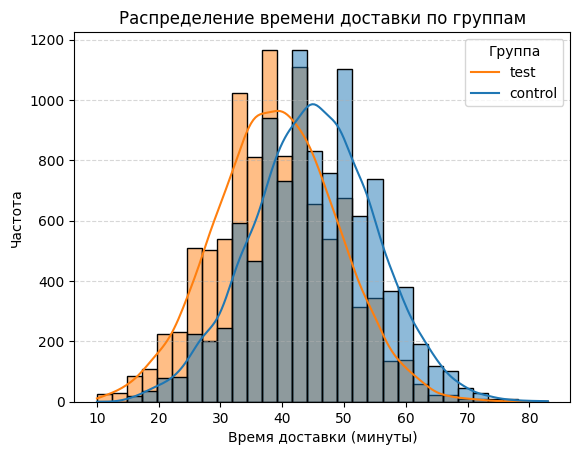

In [4]:

sns.histplot(data=data, x='delivery_time', hue='experiment_group', kde=True, bins=30, alpha=0.5)
plt.title('Распределение времени доставки по группам')
plt.xlabel('Время доставки (минуты)')
plt.ylabel('Частота')
plt.legend(title='Группа', labels = ['test', 'control'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


Описательная статистика для времени доставки заказов в контрольной и тестовой группе:

In [5]:
data.groupby('experiment_group')['delivery_time'].describe()

,count,mean,std,min,25%,50%,75%,max
experiment_group,,,,,,,,
control,10092.0,45.065101,9.990017,15.0,38.0,45.0,52.0,83.0
test,10104.0,39.046813,9.883308,10.0,32.0,39.0,46.0,75.0


In [6]:
# разделим данные по времени доставки на контрольную и тестовую группы
control_group = data[data['experiment_group'] == 'control']['delivery_time'].dropna()
test_group = data[data['experiment_group'] == 'test']['delivery_time'].dropna()

> Посчитайте количество наблюдений в тестовой и контрольной группе. На сколько по модулю отличается количество наблюдений в тесте и контроле?




In [7]:
abs(test_group.count() - control_group.count())

12

> Теперь давайте изучим наши распределения. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.


In [8]:
# проверка нормальности (тест Агостино-Пирсона)
control_normality = stats.normaltest(control_group)
test_normality = stats.normaltest(test_group)

print("Проверка нормальности распределения:")
print(f"Контрольная группа: статистика={control_normality.statistic:.3f}, p-value={control_normality.pvalue:.3f}")
print(f"Тестовая группа: статистика={test_normality.statistic:.3f}, p-value={test_normality.pvalue:.3f}")

Проверка нормальности распределения:
Контрольная группа: статистика=0.253, p-value=0.881
Тестовая группа: статистика=7.024, p-value=0.030


In [9]:
# альтернативно через pingouin
control_pg_normality = pg.normality(control_group, method='normaltest')
test_pg_normality = pg.normality(test_group, method='normaltest')

print("Результаты через pingouin:")
print(f"Контрольная группа: p-value={control_pg_normality['pval'].values[0]:.3f}")
print(f"Тестовая группа: p-value={test_pg_normality['pval'].values[0]:.3f}")

Результаты через pingouin:
Контрольная группа: p-value=0.881
Тестовая группа: p-value=0.030


Предпосылка нормальности распределения данных контрольной группы выполняется: нулевая гипотеза о нормальности распределения данных на уровне значимости `alpha = 0.05` не отклоняется (`p-value = 0.881`).

Предпосылка нормальности распределения данных тестовой группы не выполняется: нулевая гипотеза о нормальности распределения данных на уровне значимости `alpha = 0.05` отклоняется в пользу альтернативной (`p-value = 0.030`).

In [10]:
#  расчет стандартного отклонения
control_std = np.std(control_group, ddof=1)  # ddof=1 для несмещенной оценки
test_std = np.std(test_group, ddof=1)
print("Стандартное отклонение:")
print(f"Контрольная группа: {control_std:.3f}")
print(f"Тестовая группа: {test_std:.3f}")

Стандартное отклонение:
Контрольная группа: 9.990
Тестовая группа: 9.883


>  Вас могла смутить ненормальность распределения теста, полученная на прошлом шаге - однако если посмотреть на саму форму распределения, то оно не настолько сильно нарушает нормальность, чтобы об этом беспокоиться на таком размере выборки! Поэтому не переживаем 😎 Теперь пришло время сравнить средние в тесте и контроле.


**Нулевая гипотеза:** Разницы между средним временем доставки в тестовой и контрольной группе нет.

**Альтернативная гипотеза:**  Разница между средним временем доставки в тестовой и контрольной группе есть.

$$ H_0: μ_\text{test} = μ_\text{control} $$
$$ H_a: μ_\text{test} \neq μ_\text{control} $$

In [11]:
# t-тест для независимых выборок
t_stat, p_value = stats.ttest_ind(control_group, test_group)
alpha = 0.05

print("Результаты t-теста:")
print(f"t-статистика: {t_stat:.3f}, p-value: {p_value:.30f}")

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: есть статистически значимая разница между средними.")
else:
    print("Не удалось отвергнуть нулевую гипотезу: статистически значимая разница между средними отсутствует.")


Результаты t-теста:
t-статистика: 43.036, p-value: 0.000000000000000000000000000000
Отвергаем нулевую гипотезу: есть статистически значимая разница между средними.


> На сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной (округление - до сотых, разделитель - точка)?

In [12]:
print(f'{round((test_group.mean() - control_group.mean())/ control_group.mean()*100, 2)} %')

-13.35 %



**Выводы:**

**Научный:**
Результаты t-теста для независимых выборок (`t = 43.036`, `p < 0.05`) позволяют на уровне значимости 0.05 отвергнуть нулевую гипотезу о равенстве среднего времени доставки в тестовой и контрольной группе в пользу альтернативной гипотезы. Это подтверждает наличие статистически значимой разницы между средним временем доставки в тестовой и контрольной группе.

**Понятный:**
Мы провели A/B тест, чтобы оценить влияние нового алгоритма доставки с функцией "по пути" на время доставки заказов курьерами. Для этого курьеры были разделены на две группы: контрольная использовала старый алгоритм, а тестовая могла планировать последние заказы с учетом маршрута домой.
Результаты показали, что в тестовой группе, где курьеры использовали новый алгоритм, среднее время доставки уменьшилось на 13.35% по сравнению с контрольной группой. Это значительное улучшение показывает, что новая функция планирования последних заказов с учетом маршрута домой помогает курьерам доставлять заказы быстрее и эффективнее.